<a href="https://colab.research.google.com/github/tbonza/ds5220/blob/master/human_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cloudpickle
!pip install dask

In [2]:
import ast
import base64
import io
import math
import os
import zipfile

from dask import bag
from google.colab import drive
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import scipy as sp
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.python.framework import ops

Using TensorFlow backend.


In [3]:
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
X_TRAIN = "gdrive/My Drive/gcolab/X_train.hdf5"
Y_TRAIN = "gdrive/My Drive/gcolab/y_train.hdf5"
PNG_FOLDER = "gdrive/My Drive/gcolab/png/"
NPY_FOLDER = "gdrive/My Drive/gcolab/npy/"

In [0]:
def load_data(category, label, sample_size=None):
    x = np.load(NPY_FOLDER + category + ".npy")
    y = np.array([label] * x.shape[0])
      
    ## Trimming the category to sample size
    if(sample_size != None):
        x = x[:sample_size,:]
        y = y[:sample_size]
    print("Category: {}, Label: {}, X-Shape: {} & Y-Shape: {}".\
          format(category, label, x.shape, y.shape))
    return (x,y)

In [0]:
def plot_samples(input_array, rows=1, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

In [0]:
def resahape_data(x, y):
    x = x.reshape(x.shape[0], 28, 28, 1).astype('float32')
    # one hot encode outputs
    y = np_utils.to_categorical(y)
    print("After reshape, x: {}, y:{}".format(x.shape, y.shape))
    return(x, y)

In [0]:
# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# Use a 50:50 split, training the models on 10'000 samples and thus have plenty of samples to spare for testing.
def get_train_test(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x/255., y, test_size=0.5, random_state=0)
    return(x_train, x_test, y_train, y_test)

Category: fish, Label: 0, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: fork, Label: 1, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: hotdog, Label: 2, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: flamingo, Label: 3, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: airplane, Label: 4, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: alarmclock, Label: 5, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: baseballbat, Label: 6, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: bicycle, Label: 7, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: dolphin, Label: 8, X-Shape: (10000, 784) & Y-Shape: (10000,)
Category: elephant, Label: 9, X-Shape: (10000, 784) & Y-Shape: (10000,)
Shape, x: (100000, 784), y:(100000,)


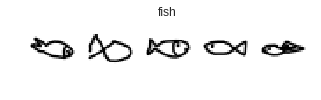

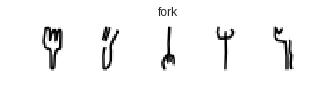

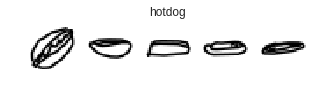

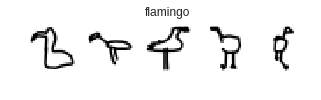

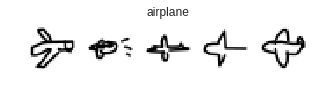

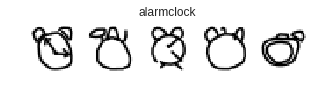

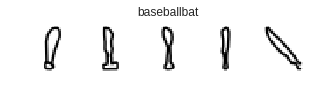

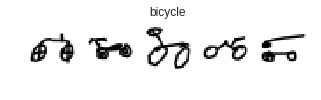

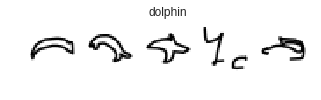

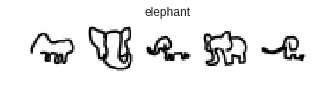

In [9]:
categories = ["fish", "fork", "hotdog", "flamingo", "airplane", "alarmclock", 
              "baseballbat", "bicycle", "dolphin", "elephant"]
#categories = ["airplane", "hotdog"]
x = None
y = None
for i in range(len(categories)):
    if(i == 0):
        x_temp, y_temp = load_data(categories[i], i, 10000)
        plot_samples(x_temp, rows=1, cols=5, title=categories[i])
        x = x_temp
        y = y_temp
    else:
        x_temp, y_temp = load_data(categories[i], i, 10000)
        plot_samples(x_temp, rows=1, cols=5, title=categories[i])
        x = np.concatenate((x, x_temp), axis=0).astype('float32')
        y = np.concatenate((y, y_temp), axis=0).astype('float32')
print("Shape, x: {}, y:{}".format(x.shape, y.shape))

In [10]:
categories

['fish',
 'fork',
 'hotdog',
 'flamingo',
 'airplane',
 'alarmclock',
 'baseballbat',
 'bicycle',
 'dolphin',
 'elephant']

In [11]:
x.shape

(100000, 784)

In [0]:
import random
import math

In [0]:
def generate_random_images(x, y, nsamples):
  """ Plot images randomly with answer key. """
  answer_key = []
  positions = []
  imgs = []
  random.seed(42)
  
  for i in range(0, nsamples):
    
    pos = random.randint(0, x.shape[0])
    img_vector = x[pos,:]
    
    # record position and correct answer
    
    positions.append(pos)
    answer_key.append(y[pos])
    
    # add image vector for review
    imgs.append(img_vector)
    
  return positions, answer_key, imgs  
    
def plot_random_images(imgs):
  rows = math.ceil(len(imgs) / 5)
  cols = 5
  
  fig, ax = plt.subplots(figsize=(cols,rows))
  ax.axis('off')
  plt.title("Image test")

  for i in range(len(imgs)):      
    a = fig.add_subplot(rows,cols,i+1)
    imgplot = plt.imshow(imgs[i].reshape((28,28)), cmap='gray_r', interpolation='nearest')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])

In [0]:
positions, answer_key, imgs = generate_random_images(x,y,100)

In [58]:
[i for i in enumerate(categories)]

[(0, 'fish'),
 (1, 'fork'),
 (2, 'hotdog'),
 (3, 'flamingo'),
 (4, 'airplane'),
 (5, 'alarmclock'),
 (6, 'baseballbat'),
 (7, 'bicycle'),
 (8, 'dolphin'),
 (9, 'elephant')]

In [0]:
human = [
    (0, 8), (1, 1), (2, 0), (3, 9), (4, 3),
    (5, 3), (6, 2), (7, 1), (8, 9), (9, 1),
    (10, 8), (11, 9), (12, 7), (13, 1), (14, 7),
    (15, 5), (16, 0), (17, 0), (18, 1), (19, 2),
    (20, 3), (21, 0), (22, 7), (23, 0), (24, 7),
    (25, None), (26, 9), (27, 8), (28, 9), (29, 7),
    (30, 5), (31, 2), (32, 5), (33, 7), (34, 3),
    (35, 0), (36, 9), (37, 2), (38, 9), (39, 4),
    (40, 4), (41, 3), (42, 2), (43, None), (44, 4),
    (45, 1), (46, 1), (47, 0), (48, 1), (49, 4),
]

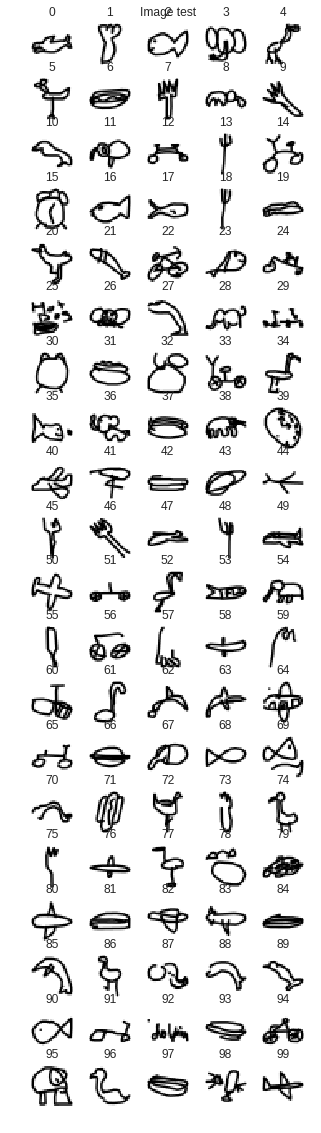

In [60]:
plot_random_images(imgs)

In [54]:
[i for i in enumerate(categories)]

[(0, 'fish'),
 (1, 'fork'),
 (2, 'hotdog'),
 (3, 'flamingo'),
 (4, 'airplane'),
 (5, 'alarmclock'),
 (6, 'baseballbat'),
 (7, 'bicycle'),
 (8, 'dolphin'),
 (9, 'elephant')]

In [0]:
human2 = [
    (50, 4), (51, 7), (52, 3), (53, 0), (54, 9),
    (55, 6), (56, 7), (57, 3), (58, 4), (59, None),
    (60, 7), (61, 3), (62, 8), (63, 8), (64, None),
    (65, 7), (66, 2), (67, 0), (68, 0), (69, 0),
    (70, 9), (71, 2), (72, 3), (73, 1), (74, 0),
    (75, 1), (76, 4), (77, 3), (78, 5), (79, None),
    (80, 4), (81, 2), (82, 4), (83, 4), (84, 2),
    (85, 8), (86, 3), (87, None,), (88, 8), (89, 8),
    (90, 0), (91, 7), (92, None), (93, 2), (94, 7),
    (95, 9), (96, 3), (97, 2), (98, None), (99, 4),
    
]

In [0]:
human_scored = [
    (0, 8), (1, 1), (2, 0), (3, 9), (4, 3),
    (5, 3), (6, 2), (7, 1), (8, 9), (9, 1),
    (10, 8), (11, 9), (12, 7), (13, 1), (14, 7),
    (15, 5), (16, 0), (17, 0), (18, 1), (19, 2),
    (20, 3), (21, 0), (22, 7), (23, 0), (24, 7),
    (25, None), (26, 9), (27, 8), (28, 9), (29, 7),
    (30, 5), (31, 2), (32, 5), (33, 7), (34, 3),
    (35, 0), (36, 9), (37, 2), (38, 9), (39, 4),
    (40, 4), (41, 3), (42, 2), (43, None), (44, 4),
    (45, 1), (46, 1), (47, 0), (48, 1), (49, 4),
    (50, 4), (51, 7), (52, 3), (53, 0), (54, 9),
    (55, 6), (56, 7), (57, 3), (58, 4), (59, None),
    (60, 7), (61, 3), (62, 8), (63, 8), (64, None),
    (65, 7), (66, 2), (67, 0), (68, 0), (69, 0),
    (70, 9), (71, 2), (72, 3), (73, 1), (74, 0),
    (75, 1), (76, 4), (77, 3), (78, 5), (79, None),
    (80, 4), (81, 2), (82, 4), (83, 4), (84, 2),
    (85, 8), (86, 3), (87, None,), (88, 8), (89, 8),
    (90, 0), (91, 7), (92, None), (93, 2), (94, 7),
    (95, 9), (96, 3), (97, 2), (98, None), (99, 4),
]

In [72]:
len(human_scored)

100

In [74]:
len(answer_key)

100

In [0]:
correct = 0
for human, answer in zip(human_scored, answer_key):
  
  if human[1] == int(answer):
    correct += 1

In [83]:
print("Human correct percentage: {}".format((correct / len(answer_key) * 100)))


Human correct percentage: 85.0
